# Library

In [43]:
# Data
import pandas as pd
import numpy as np

# Graph
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Stats
from scipy.stats import shapiro, ttest_1samp
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Save Model
import joblib

#Warnings
import warnings
warnings.filterwarnings('ignore')


# Data

In [2]:
cars = pd.read_csv('auto-mpg.csv')
cars.head()

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Desrcibe data
- mpg: continuous 
- cylinders: multi-valued 
- discretedisplacement: continuous
- horsepower: continuous
- weight: continuous
- acceleration: continuous
- model year: multi-valued discrete
- origin: multi-valued discrete
- car name: string (unique for each instance)

In [3]:
cars.dtypes

mpg       float64
cyl         int64
displ     float64
hp          int64
weight      int64
accel     float64
yr          int64
origin      int64
name       object
dtype: object

In [4]:
cars.shape

(392, 9)

We can change origin column with categorical data, so later we can use dummies variabel

In [5]:
cars['origin'] = cars['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})

# EDA

## Missing Value

In [6]:
cars.isna().sum()

mpg       0
cyl       0
displ     0
hp        0
weight    0
accel     0
yr        0
origin    0
name      0
dtype: int64

In [7]:
# Check Any missing value with another character, such as '0', '?', etc
cars[(cars == 0) | (cars == "?")]

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No Missing value for this Dataset

## Correlation and Normality

### Graph Method for Correlation and Nomality

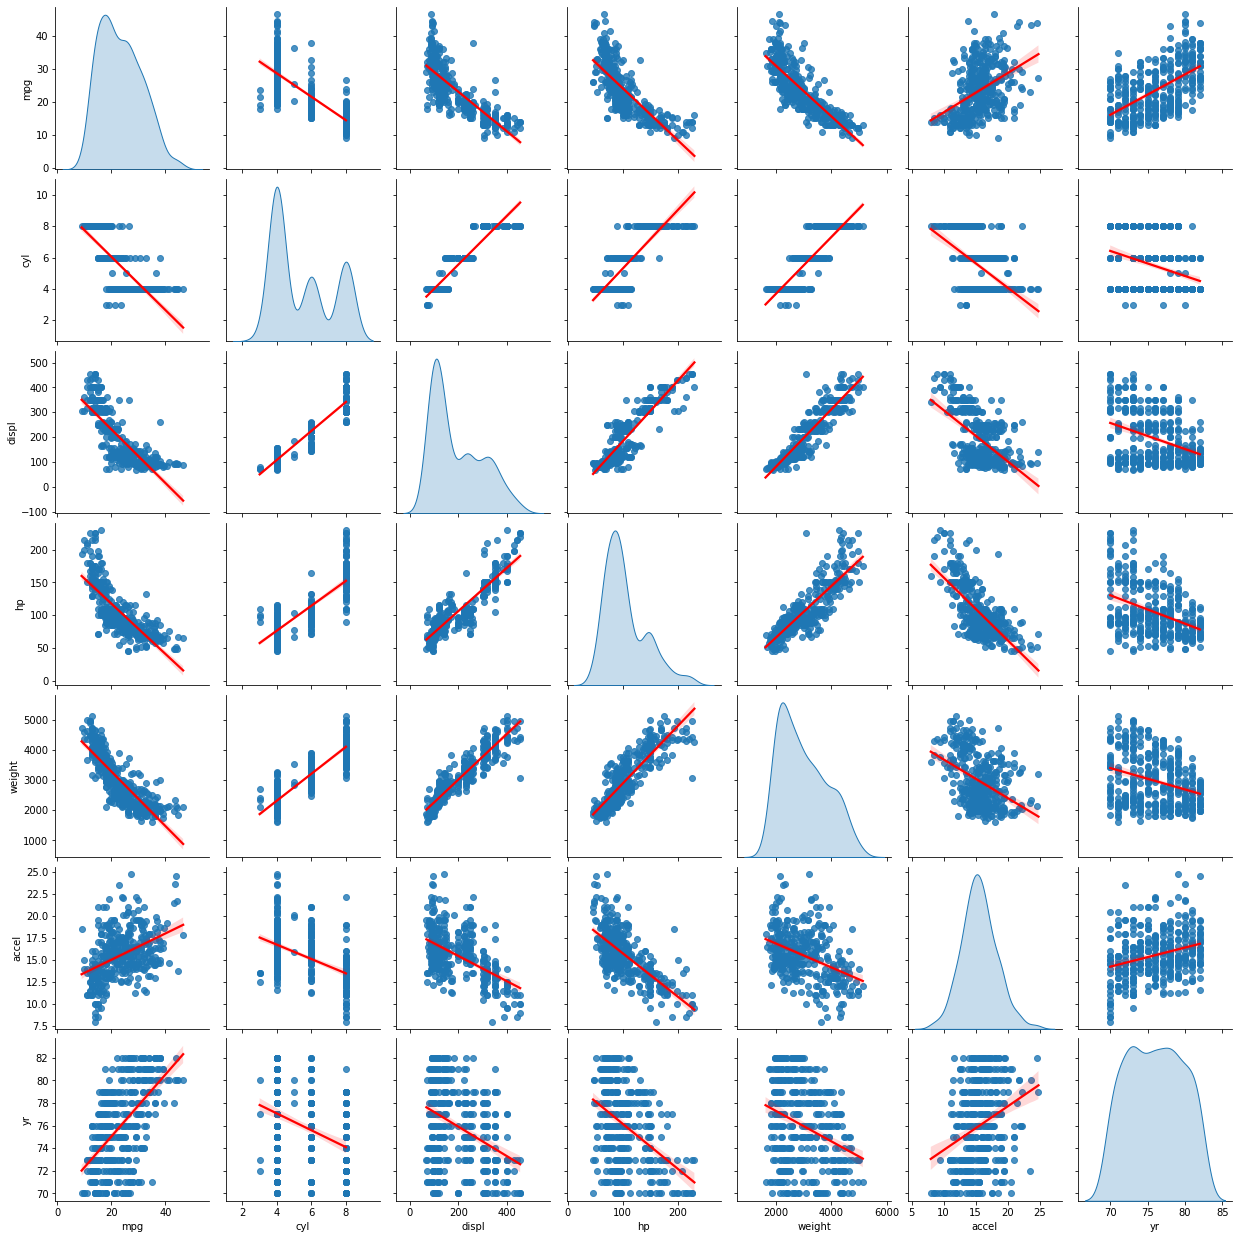

In [8]:
sns.pairplot(cars.iloc[:, 0:7], diag_kind = 'kde', kind = 'reg', plot_kws = {'line_kws': {'color' : 'red'}})

#### Box Plot:

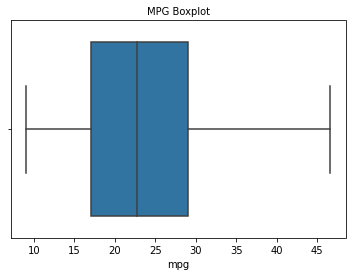

In [9]:
sns.boxplot(x = cars['mpg'])
plt.title("MPG Boxplot", size = 10)
plt.show()

#### Conclusion:
- In this Method we can see:
    - MPG has strong correlation with cyl, hp, and disp. And MPG looks like little bit skewed
    - From this graph, we can see maybe only 'accel' variable has normality distribution
- With graph method, it's hard to see strength correlation and the normality. So it will be better if we look numerically
- In MPG Boxplot, there's no outliers, so in evaluation we can choose RMSE

### Normality Test:
- H0: Variable has normal distribution
- H1: Variable doesn't has normal distribution
- Alpha: 0.05

In [10]:
varTest = cars.columns[0:7]

for i in varTest:
    shapiroStat, shapiroPval = shapiro(cars[f"{i}"])
    if shapiroPval < 0.05:
        print(f"Pval = {shapiroPval} \nWe assume {i} variable doesn't has normal distribution\n")
    else:
        print(f"Pval = {shapiroPval} \nWe assume {i} variable has normal distribution\n")


Pval = 1.0494927948911936e-07 
We assume mpg variable doesn't has normal distribution

Pval = 6.879383008559237e-24 
We assume cyl variable doesn't has normal distribution

Pval = 8.984704126397468e-17 
We assume displ variable doesn't has normal distribution

Pval = 5.021926207130975e-15 
We assume hp variable doesn't has normal distribution

Pval = 2.601725432316293e-11 
We assume weight variable doesn't has normal distribution

Pval = 0.03054318018257618 
We assume accel variable doesn't has normal distribution

Pval = 1.2219598943818966e-10 
We assume yr variable doesn't has normal distribution



Well, now we can asumme no one variable has normal distribution. So we can't choose mean as our central tendency

### Measure Central Tendency

In [11]:
cars.describe()

,mpg,cyl,displ,hp,weight,accel,yr
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [12]:
cars.describe(include='O')

,origin,name
count,392,392
unique,3,301
top,america,toyota corolla
freq,245,5


### Correlation:
- Because our variable doesn't has normal distribution. We need use Spearman correlation

<AxesSubplot:>

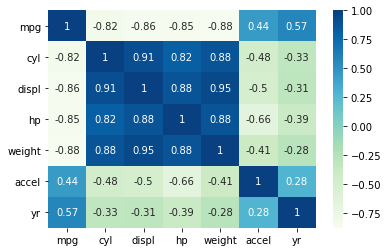

In [13]:
corrMatrix = cars.corr(method= 'spearman')

#Heatmap 
sns.heatmap(corrMatrix, annot = True ,cmap = 'GnBu')

Well, from this we can see variable accel who has lowest correlation with MPG

## VIF (Variance inflation factor):
I want calculate VIF to see. Is there variable that has multicolinearity. <br>
If there has multicolinearity i will choose Ridge model or Lasso, if not let's try Linear Regression only 

In [14]:
#Calc VIF function
def calcVif(x):
    vif = pd.DataFrame()
    vif['variable'] = x.columns
    vif['vif'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif    

In [15]:
calcVif(cars.iloc[:, 0:7].drop(columns='mpg'))

,variable,vif
0,cyl,115.977772
1,displ,86.485956
2,hp,60.256575
3,weight,137.471756
4,accel,69.400877
5,yr,109.320016


There have serious problem about multicolinearity. So, I will use Ridge or Lasso model to make model. But I will check Linear Regression too

# Splitting Data

In [16]:
#Independent variable
X = cars.drop(columns=["mpg", 'name'])

#Dependent variabel
y = cars[['mpg']]

In [17]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Preprocessing Sceheme

In [18]:
onehot = OneHotEncoder(drop='first')
onehotVar = ['origin']

minmaxVar = ['cyl', 'displ', 'hp', 'weight']

polynom = PolynomialFeatures(degree = 2, include_bias=False)

transfomer = ColumnTransformer([
                                ('one hot encoder', onehot, onehotVar),
                                ('min max scaler', MinMaxScaler(), minmaxVar)
], remainder= 'passthrough')

In [19]:
def modelEvaluation(model, metrics):
    estimator = Pipeline([
                          ('transformer', transfomer),
                          ('polynomial feature', polynom),
                          ('model', model)
    ])

    model_cv = abs(cross_val_score(estimator, xTrain, yTrain, scoring = metrics))

    print('Hasil cross val ', model_cv)
    print('CV Score Mean: ', abs(model_cv.mean()))
    print('CV Score Std: ', abs(model_cv.std()))

In [31]:
ridge = Ridge(alpha= 1)
lasso = Lasso()
linear = LinearRegression()

# Modeling

## Benchmark

In [21]:
modelEvaluation(ridge, 'neg_mean_absolute_percentage_error')

Hasil cross val  [0.08713001 0.07973714 0.1032471  0.07895985 0.07586187]
CV Score Mean:  0.08498719381454146
CV Score Std:  0.009850678462459274


In [22]:
modelEvaluation(lasso, 'neg_mean_absolute_percentage_error')

Hasil cross val  [0.11310191 0.12608603 0.12151192 0.12860206 0.09316448]
CV Score Mean:  0.1164932787895588
CV Score Std:  0.012802847737731571


In [23]:
modelEvaluation(linear, 'neg_mean_absolute_percentage_error')

Hasil cross val  [0.0970336  0.0903951  0.10042495 0.08896627 0.09196814]
CV Score Mean:  0.093757613393229
CV Score Std:  0.004304675301377939


As We can see. Ridge is the best model if we only look from MAPE, but Lasso more robust than ridge.<br>
Actually, Linear Regression is not a bad model, but if we decide to use Linear Regression we can't tunning the hyperparameter

# Hyperparameter Tuning:
- alpha of Ridge and Lasso model
- degree of polynom

## Benchmark Model to predict Test set and Check our model is overfitting or not

In [24]:
def modelBenchmark(model):
    estimator = Pipeline([
                          ('transformer', transfomer),
                          ('polynomial feature', polynom),
                          ('model', model)
    ])

    estimator.fit(xTrain, yTrain)

    yPred1 = estimator.predict(xTrain)
    yPred2 = estimator.predict(xTest)

    print(f'MAPE train set from {type(model).__name__}: {(mean_absolute_percentage_error(yTrain, yPred1)) * 100} %')
    print(f'MAPE test set from {type(model).__name__}: {(mean_absolute_percentage_error(yTest, yPred2)) * 100} %\n')

In [32]:
modelBenchmark(ridge)
modelBenchmark(lasso)

MAPE train set from Ridge: 8.000022494681836 %
MAPE test set from Ridge: 8.809365117991504 %

MAPE train set from Lasso: 11.103960498142362 %
MAPE test set from Lasso: 11.435596816454632 %



In [33]:
pipeModel = Pipeline([
        ('transformer', transfomer),
        ('polynomial_feature', polynom),
        ('model', ridge)
    ])

hyperparams = {
    'polynomial_feature__degree' : [2,3,4],
    'model__alpha' : [0.01, 0.1, 1, 10, 100],
    'model': [ridge, lasso]
}

gridModel = GridSearchCV(
    pipeModel,
    param_grid= hyperparams,
    cv = 5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs= -1
)

In [34]:
gridModel.fit(xTrain, yTrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['origin']),
                                                                        ('min '
                                                                         'max '
                                                                         'scaler',
                                                                         MinMaxScaler(),
                                                                         ['cyl'

In [28]:
print(gridModel.best_score_)
print(gridModel.best_params_)

-0.0848865015276163
{'model': Ridge(alpha=0.1), 'model__alpha': 0.1, 'polynomial_feature__degree': 2}


In [29]:
result = pd.DataFrame(gridModel.cv_results_)
result[result['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_polynomial_feature__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.022939,0.002185,0.012766,0.000977,Ridge(alpha=0.1),0.1,2,"{'model': Ridge(alpha=0.1), 'model__alpha': 0....",-0.088475,-0.081683,-0.09994,-0.079358,-0.074977,-0.084887,0.008701,1


### From this i can take conclusion, Ridge model has better performance when the alpha = 0.1 and degree of polynomial feature = 2. But I will make sure by comparing before after hyperparameter tuning

## Comparison Before After

In [36]:
# Before
model = Ridge()
polynom = PolynomialFeatures(degree = 2)
pipe = Pipeline([
    ('transformer', transfomer),
    ('polynom', polynom),
    ('model', model)
])

In [38]:
pipe.fit(xTrain, yTrain)
yPred = pipe.predict(xTest)
print((mean_absolute_percentage_error(yTest, yPred)*100), "%")

8.809365117991396 %


In [39]:
afterTuningModel = gridModel.best_estimator_

In [42]:
afterTuningModel.fit(xTrain, yTrain)
yPred = afterTuningModel.predict(xTest)
print((mean_absolute_percentage_error(yTest, yPred) * 100), "%")

8.720378724640307 %


# Conclusion: <br>
- As we can see, after Hyperparameter tuning model have improved the performance, though not significant

# Save Model

In [44]:
#Save Model
joblib.dump(gridModel.best_estimator_, 'RidgeModel')

['RidgeModel']

In [45]:
#Load Model
loadedModel = joblib.load('RidgeModel')

In [48]:
newDataToPredict = pd.DataFrame({
    'cyl': [8, 6, 4],
    'displ': [92, 86, 81],
    'hp': [70, 82, 83],
    'weight': [2189,1820, 1959],
    'accel': [13.3, 14.5, 15],
    'yr': [72, 77, 78],
    'origin': ['europe', 'asia', 'america']
})

In [53]:
mpgPredict = loadedModel.predict(newDataToPredict)

In [54]:
newDataToPredict['mpg'] = mpgPredict

In [55]:
newDataToPredict

,cyl,displ,hp,weight,accel,yr,origin,mpg
0,8,92,70,2189,13.3,72,europe,19.978647
1,6,86,82,1820,14.5,77,asia,34.330216
2,4,81,83,1959,15.0,78,america,31.846902
